In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d landlord/handwriting-recognition

Dataset URL: https://www.kaggle.com/datasets/landlord/handwriting-recognition
License(s): CC0-1.0
 99% 1.25G/1.26G [00:05<00:00, 251MB/s]
100% 1.26G/1.26G [00:05<00:00, 242MB/s]


In [ ]:
!unzip handwriting-recognition.zip -d handwriting_data

Streaming output truncated to the last 5000 lines.
  inflating: handwriting_data/validation_v2/validation/VALIDATION_5003.jpg  
  inflating: handwriting_data/validation_v2/validation/VALIDATION_5004.jpg  
  inflating: handwriting_data/validation_v2/validation/VALIDATION_5005.jpg  
  inflating: handwriting_data/validation_v2/validation/VALIDATION_5006.jpg  
  inflating: handwriting_data/validation_v2/validation/VALIDATION_5007.jpg  
  inflating: handwriting_data/validation_v2/validation/VALIDATION_5008.jpg  
  inflating: handwriting_data/validation_v2/validation/VALIDATION_5009.jpg  
  inflating: handwriting_data/validation_v2/validation/VALIDATION_5010.jpg  
  inflating: handwriting_data/validation_v2/validation/VALIDATION_5011.jpg  
  inflating: handwriting_data/validation_v2/validation/VALIDATION_5012.jpg  
  inflating: handwriting_data/validation_v2/validation/VALIDATION_5013.jpg  
  inflating: handwriting_data/validation_v2/validation/VALIDATION_5014.jpg  
  inflating: handwriting_

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Reshape, Bidirectional,
    LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
)
from tensorflow.keras.optimizers import Adam

In [ ]:
train = pd.read_csv('/content/handwriting_data/written_name_train_v2.csv')
valid = pd.read_csv('/content/handwriting_data/written_name_validation_v2.csv')

In [ ]:
train

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE
...,...,...
330956,TRAIN_330957.jpg,LENNY
330957,TRAIN_330958.jpg,TIFFANY
330958,TRAIN_330959.jpg,COUTINHO DESA
330959,TRAIN_330960.jpg,MOURAD


In [ ]:
valid

,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP
...,...,...
41365,VALIDATION_41366.jpg,CHAILLAN
41366,VALIDATION_41367.jpg,BAROUH
41367,VALIDATION_41368.jpg,MAXENCE
41368,VALIDATION_41369.jpg,HAMELIN


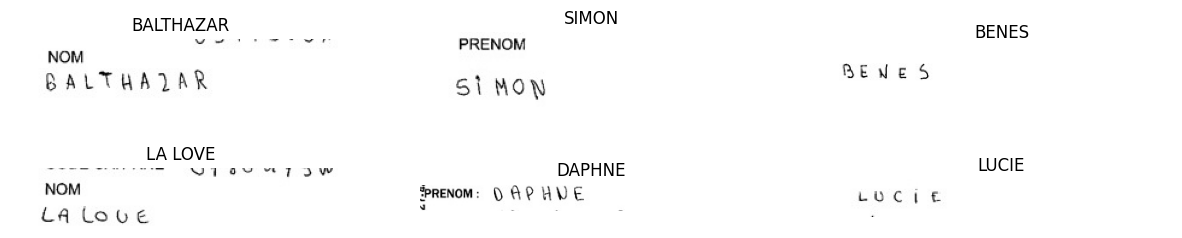

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/handwriting_data/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [ ]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41370 entries, 0 to 41369
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  41370 non-null  object
 1   IDENTITY  41292 non-null  object
dtypes: object(2)
memory usage: 646.5+ KB


In [ ]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [ ]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

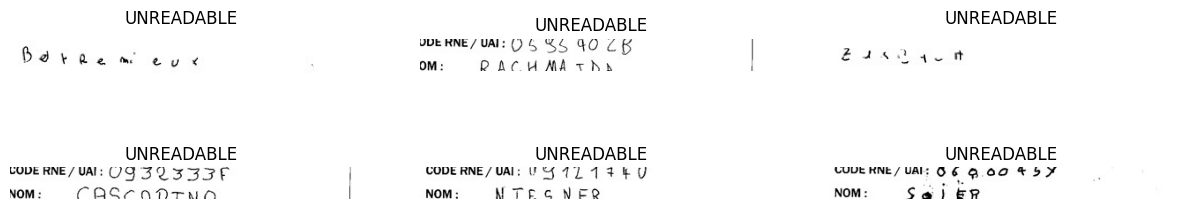

In [ ]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/handwriting_data/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [ ]:
train.loc[:, 'IDENTITY'] = train['IDENTITY'].str.upper()
valid.loc[:, 'IDENTITY'] = valid['IDENTITY'].str.upper()


In [ ]:
train.reset_index(inplace = True, drop=True)
valid.reset_index(inplace = True, drop=True)

In [ ]:
def preprocess(img):
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255

    # crop
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]


    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [ ]:
train_size = 21000
valid_size= 2100

In [ ]:
train_x = []

for i in range(train_size):
    img_dir = '/content/handwriting_data/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [ ]:
valid_x = []

for i in range(valid_size):
    img_dir = '/content/handwriting_data/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [ ]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [ ]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels

def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [ ]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [ ]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100],
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [ ]:
# Input layer: expects grayscale images of shape (256, 64, 1)
input_data = Input(shape=(256, 64, 1), name='input')

# First Convolutional Block
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

# Second Convolutional Block
inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  #
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

# Third Convolutional Block
inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  # 128 filters, 3x3 kernel
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# Reshape layer to prepare for RNN input
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)  # Reshape to (64, 1024)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# Recurrent Neural Network (RNN) Layers
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)  # Bidirectional LSTM with 256 units, returns sequences
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)  # Another Bidirectional LSTM with 256 units

# Output layer
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

# Model definition
model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 256, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 256, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 128, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 64, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling2D)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (Bidirectional)           │ (None, 64, 512)        │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (Bidirectional)           │ (None, 64, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64, 30)         │        15,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 64, 30)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,406,878 (9.18 MB)

 Trainable params: 2,406,430 (9.18 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
# Inputs
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

# Move slicing outside the ctc_lambda_func to avoid tf.function error
y_pred_sliced = Lambda(lambda x: x[:, 2:, :], name='y_pred_sliced')(y_pred)

# Define the CTC loss function without slicing inside
def ctc_lambda_func(args):
    y_pred_sliced, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred_sliced, input_length, label_length)

# CTC loss layer
ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [y_pred_sliced, labels, input_length, label_length]
)

# Final model that includes inputs for data and CTC loss calculation
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [ ]:
from tensorflow.keras.optimizers import Adam

# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=0.0001))


In [ ]:
history = model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
                          validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                          epochs=60, batch_size=128)

Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 64s 297ms/step - loss: 53.8936 - val_loss: 21.8730
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 74s 287ms/step - loss: 20.4997 - val_loss: 20.5141
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 82s 288ms/step - loss: 20.1718 - val_loss: 20.2473
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 81s 282ms/step - loss: 19.9599 - val_loss: 20.0000
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 47s 286ms/step - loss: 19.7136 - val_loss: 19.7065
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 84s 298ms/step - loss: 19.4852 - val_loss: 19.5373
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 47s 285ms/step - loss: 19.0117 - val_loss: 19.1817
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 48s 290ms/step - loss: 18.4573 - val_loss: 17.6790
Epoch 9/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 48s 288ms/step - loss: 17.3315 - val_loss: 16.7408
Epoch 10/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 48s 293ms/step - loss: 16.0813 - val_loss: 15.9899
Epoch 11/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 81s 287ms/step - loss: 14.6542 - val_loss: 14.58

In [ ]:
model_final.save('model_final.h5')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


# Define the path to save the model in Google Drive
model_save_path = '/content/drive/My Drive/handwriting_recognition_model/model_final.h5'

# Save the trained model to Google Drive
model_final.save(model_save_path)

print(f"Model saved to: {model_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to: /content/drive/My Drive/handwriting_recognition_model/model_final.h5


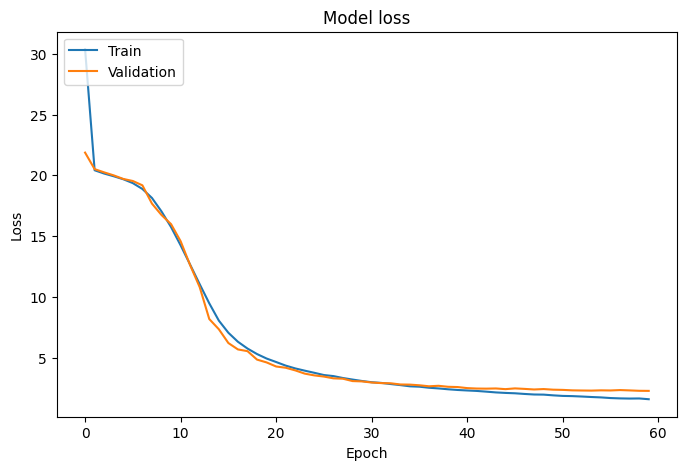

In [ ]:
# Function to plot the training history
def plot_training_history(history):
    plt.figure(figsize=(8,5))

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot the training history
plot_training_history(history)

In [ ]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [ ]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 85.64%
Correct words predicted      : 70.62%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


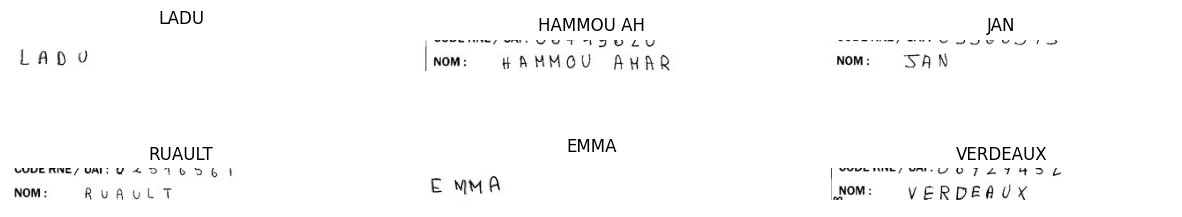

In [ ]:
test = pd.read_csv('/content/handwriting_data/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(100,106):
    ax = plt.subplot(2, 3, i - 100 + 1)
    img_dir = '/content/handwriting_data/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

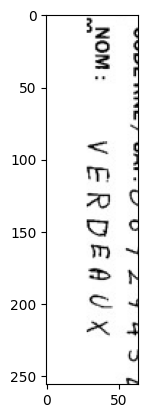

In [ ]:
im = cv2.imread('/content/handwriting_data/TEST_0005.jpg', cv2.IMREAD_GRAYSCALE)
im = preprocess(im)
plt.imshow(im, cmap='gray')

In [ ]:
pred = model.predict(im.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                       greedy=True)[0][0])
num_to_label(decoded[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


'VERDEAUX'

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
@tf.keras.utils.register_keras_serializable()
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]  # Skip the first two outputs
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


In [ ]:
# CTC loss layer
ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [y_pred_sliced, labels, input_length, label_length]
)


In [ ]:
model_final.save('modelFinal.h5')


In [ ]:
model.save('my_model_final.keras')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Saving in HDF5 format
model_final.save('/content/drive/MyDrive/modelFinal.h5')

# Saving in new Keras format
model.save('/content/drive/MyDrive/my_model_final.keras')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
